# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже поменяли тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [190]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Импортирую библиотеку для отображения статус-бара
import tqdm

## Откройте и изучите файл

In [191]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [192]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Посмотрим распределения значений

In [193]:
# запишем сводные данные в таблицу
res_table = data.describe()
res_table

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


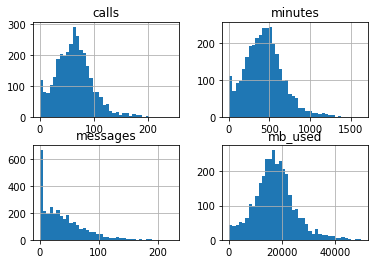

In [194]:
data.drop(['is_ultra'],axis=1).hist(bins=40);

Видим, что около нуля сосредоточено большое количество значений.
Отдельно посмотрим распределения значений в нижнем (1%) квантиле

In [195]:
# функция для обрезки значений поля
def cut(data,clmn,qmn,qmx): # qmn,qmx- нижний и верхний квантили
    out = data[(data[clmn]<=data[clmn].
   quantile(qmx)) & (data[clmn]>=data[clmn].
   quantile(qmn))][clmn]
    return out

In [196]:
# запишем на память
fit_list = ['calls','minutes','messages','mb_used']
targ_list= ['is_ultra']
clmn_list= fit_list+targ_list

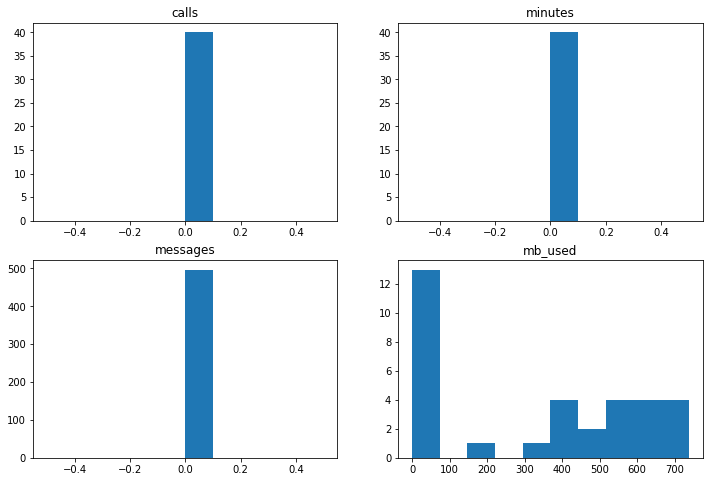

In [197]:
cutoff = 0.01
figure, axis = plt.subplots(2, 2, figsize=(12,8))
axis[0,0].hist(cut(data,'calls',0,cutoff))
axis[0,0].set_title('calls')
axis[0,1].hist(cut(data,'minutes',0,cutoff))
axis[0,1].set_title('minutes')
axis[1,0].hist(cut(data,'messages',0,cutoff))
axis[1,0].set_title('messages')
axis[1,1].hist(cut(data,'mb_used',0,cutoff))
axis[1,1].set_title('mb_used')
plt.show()

Отдельно посмотрим данные в поле is_ultra

In [198]:
data['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

В поле is_ultra действительно содержится только два значения (0 - 69% и 1 - 31%)

Посчитаем доли значений равных нулю для всех полей

In [199]:
for clmn in clmn_list:
    res_table.loc['zerro_count',clmn]=data[data[clmn]==0][clmn].count()/len(data)
res_table

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000
zerro_count,0.012446,0.012446,0.154636,0.003423,0.693528


Видим, что поле "messages" действительно сосредотачивает в нуле значительную долю (15,5%) значений. А calls и minutes всего лишь 1,2%

Также посмотрим сводные таблицы отдельно для двух тарифов

In [200]:
# сводные метрики для тарифо УЛЬТРА
res_table_ultra = data[data['is_ultra']==1].describe()
for clmn in clmn_list:
    res_table_ultra.loc['zerro_count',clmn]=data[
                        (data[clmn]==0) & data['is_ultra']==1][clmn].count()/len(data)
res_table_ultra

,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0
zerro_count,0.010579,0.010579,0.059116,0.003111,0.0


In [201]:
# Сводные метрики для тарифа СМАРТ
res_table_smart = data[data['is_ultra']==0].describe()
for clmn in clmn_list:
    res_table_smart.loc['zerro_count',clmn]=data[
                        (data[clmn]==0) & data['is_ultra']==0][clmn].count()/len(data)
res_table_smart

,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0
zerro_count,0.989421,0.989421,0.940884,0.996889,1.0


Видим, что практически все нулевые значения - на СМАРТе. Пользователи Ультры почти всегда "выбирают" оплаченное.

Также вполне ожидаемое превышение значений в тарифе ультра. Для наглядности стравним метрики

In [202]:
idx = res_table.index
res_table_diff = pd.DataFrame(index = idx)
for i in idx:
    for clmn in clmn_list:
        if res_table_smart.loc[i,clmn] != 0:
            res_table_diff.loc[i,clmn]=((res_table_ultra.loc[i,clmn]-res_table_smart.loc[i,clmn])/
                                        res_table_smart.loc[i,clmn])
        else:
            res_table_diff.loc[i,clmn] = 0
res_table_diff

,calls,minutes,messages,mb_used,is_ultra
count,-0.558098,-0.558098,-0.558098,-0.558098,-0.558098
mean,0.255364,0.259351,0.478655,0.201151,0.000000
std,0.693026,0.669431,0.693519,0.718283,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025000,0.006564,-0.400000,-0.069032,0.000000
50%,0.233333,0.224060,0.357143,0.169691,0.000000
75%,0.368421,0.378728,0.549020,0.339003,0.000000
max,0.232323,0.173958,0.566434,0.290333,0.000000
zerro_count,-0.989308,-0.989308,-0.937169,-0.996879,-1.000000


Отметим значительное превышение стандартного отклонения Ультры над Смартом по всем полям. Также 75% квантиль поля messages Ультры значительно превышает Смарт, при обратной пропорции в 25% квартиле (на Ультре в целом больше пользутся сообщениями, при этом активные пользователи сообщений на Ультре более активны)

Посмотрим также корреляцию признаков в целом по датасету и отдельно для двух тарифов

In [203]:
data[fit_list].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


In [204]:
data[data['is_ultra']==1][fit_list].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.988235,0.087691,0.176856
minutes,0.988235,1.000000,0.083000,0.178003
messages,0.087691,0.083000,1.000000,0.173710
mb_used,0.176856,0.178003,0.173710,1.000000


In [205]:
data[data['is_ultra']!=1][fit_list].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.972654,0.208789,0.357349
minutes,0.972654,1.000000,0.203746,0.341639
messages,0.208789,0.203746,1.000000,0.146499
mb_used,0.357349,0.341639,0.146499,1.000000


Имеем:
- понятную почти 100% прямую зависимость между звонками и минутами (возможно, этот признак вообще имеет смысл исключить для МО?)
- слабую прямую зависимость сообщений с другими полями (в Ультре заметно слабее)
- условно среднюю прямую зависимость для Смарта между мегабайтами и звонками
- условно слабую прямую зависимость для Ультры между мегабайтами и другими полями

Последнее- посмотрим диаграммы рассеяния для признаков

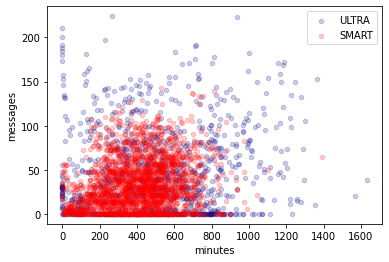

In [206]:
ax = data[data['is_ultra']==1].plot.scatter(x='minutes',y='messages',color="DarkBlue", label="ULTRA",alpha=0.2)
data[data['is_ultra']==0].plot.scatter(x='minutes',y='messages',color="Red", label="SMART", alpha=0.2, ax=ax);

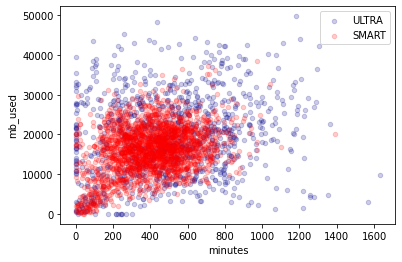

In [207]:
ax = data[data['is_ultra']==1].plot.scatter(x='minutes',y='mb_used',color="DarkBlue", label="ULTRA",alpha=0.2)
data[data['is_ultra']==0].plot.scatter(x='minutes',y='mb_used',color="Red", label="SMART", alpha=0.2, ax=ax);

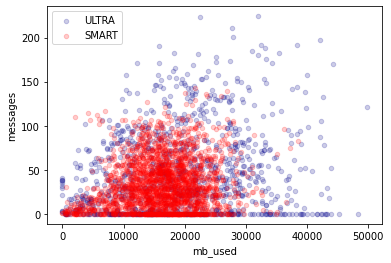

In [208]:
ax = data[data['is_ultra']==1].plot.scatter(x='mb_used',y='messages',color="DarkBlue", label="ULTRA",alpha=0.2)
data[data['is_ultra']==0].plot.scatter(x='mb_used',y='messages',color="Red", label="SMART", alpha=0.2, ax=ax);

Видим, что данные СМАРТа сильнее сконцентрированы возле своего "ядра". В остальном- "руками не рассортируешь".

Ну что ж. Начнем ворожить!

## Разбейте данные на выборки

In [209]:
features = data[fit_list]
target = data[targ_list]
# разделим выборку на обучающую и тестовую
features_train_undiv, features_test, target_train_undiv, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
# еще раз разделим теперь уже обучающую выборку на обучающую и валидационную
# установим параметр  сплита выборки
fetch = 0.25
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_undiv, target_train_undiv, test_size=0.2, random_state=12345)
display('Обучающая выборка признаков',features_train.shape)
display('Валидационная выборка  признаков',features_valid.shape)
display('Тестовая выборка  признаков',features_test.shape)

'Обучающая выборка признаков'

(2056, 4)

'Валидационная выборка  признаков'

(515, 4)

'Тестовая выборка  признаков'

(643, 4)

## Исследуйте модели

### Пробные значения для моделей

Рассчитаем пробные значения для моделей с гиперпараметрами, которые использовались в рамках спринта по МО

In [210]:
# сведем данные в датафреймы
# запишем эти манипуляции в виде функции
def models_df():
    # модель решающего дерева
    md = 5 # введем переменную для глубины
    model_dtcl = DecisionTreeClassifier(random_state=12345, max_depth=md)
    model_dtcl.fit(features_train, target_train)
    predictions_train = model_dtcl.predict(features_train)
    accuracy_dtcl_train = accuracy_score(target_train, predictions_train)
    predictions_valid = model_dtcl.predict(features_valid)
    accuracy_dtcl_valid = accuracy_score(target_valid, predictions_valid)

    # модель случайного леса
    est = 40 # переменная для количества оценщиков
    model_rfcl = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_rfcl.fit(features_train, target_train)
    predictions_train = model_rfcl.predict(features_train)
    accuracy_rfcl_train = accuracy_score(target_train, predictions_train)
    predictions_valid = model_rfcl.predict(features_valid)
    accuracy_rfcl_valid = accuracy_score(target_valid, predictions_valid)

    # модель логистической регрессии
    itr = 1000 # переменная для количества итераций
    model_logr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
    model_logr.fit(features_train, target_train)
    predictions_train = model_logr.predict(features_train)
    accuracy_logr_train = accuracy_score(target_train, predictions_train)
    predictions_valid = model_logr.predict(features_valid)
    accuracy_logr_valid = accuracy_score(target_valid, predictions_valid)
    
    out_dtcl = pd.DataFrame() # для решающего дерева
    out_dtcl.loc[0,['common_fetch','dtcl_depth','accuracy_dtcl_train','accuracy_dtcl_valid']]=[
                                        fetch,md,accuracy_dtcl_train,accuracy_dtcl_valid]
    
    out_rfcl = pd.DataFrame() # для случайного леса
    out_rfcl.loc[0,['common_fetch','rfcl_estimators','accuracy_rfcl_train','accuracy_rfcl_valid']]=[
                                        fetch,est,accuracy_rfcl_train,accuracy_rfcl_valid]
    
    out_logr = pd.DataFrame() # для случайного леса
    out_logr.loc[0,['common_fetch','logr_iter','accuracy_logr_train','accuracy_logr_valid']]=[
                                        fetch,itr,accuracy_logr_train,accuracy_logr_valid]
    
    return out_dtcl, out_rfcl, out_logr, model_dtcl, model_rfcl, model_logr

out_dtcl, out_rfcl, out_logr, model_dtcl, model_rfcl, model_logr = models_df()

display(out_dtcl)
display(out_rfcl)
display(out_logr)

,common_fetch,dtcl_depth,accuracy_dtcl_train,accuracy_dtcl_valid
0,0.25,5.0,0.828307,0.757282


,common_fetch,rfcl_estimators,accuracy_rfcl_train,accuracy_rfcl_valid
0,0.25,40.0,0.998541,0.778641


,common_fetch,logr_iter,accuracy_logr_train,accuracy_logr_valid
0,0.25,1000.0,0.753891,0.716505


Видим, что случайный лес дает 100% качество на тренировочной выборке и значительно снижает на валидационной. Качество для логистической регрессии устойчиво на валидационной выборке.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

**Видим, что случайный лес дает 100% качество на тренировочной выборке и значительно снижает на валидационной** - это так и есть. Это просто данность, присущая такому методу проверки.
</div>

### Оптимизация по одному параметру для модели

Посмотрим как влияет изменение основных параметров (в соотвествии с теорией) для выбранных моделей:
- лог.регрессия - количество итераций
- дерево решений - максимальная глубина
- случайный лес - количество оценщиков

Оценивать будем качество только на обучающей выборке. Посмотрим как качество будет себя вести для разных разбиений обучающей выборки (тестовую выборку (20% от исходного датасета) не трогаем- делим в разных пропорциях оставшиеся 80%)

Используется статус бар - следующий цикл на моем компьютере занимает около 2 минут

### Оптимизация нескольких параметров

Посмотрим варианты комбинаций гиперпараметров для наших моделей. Проверим изменение качества.

Определим оптимизируемые гиперпараметры.

Для логистической регрессии:
- solver - оставим lbfgs, поскольку остальные варианты не подходят для нашей задачи и нашего датасета (относительно небольшое количество строк и полей, также - у нас всего 2 класса)
- penalty - ['l2', ‘none’] - доступные варианты для solver='lbfgs'
- C - будем менять [0.1,0.5,1,5,10,30,50,100,200]
- class_weightdict - оставим default=None (считаем, что соотноние классов 30/70 - сбалансированное)
- max_iter - оставим дефолтное значение

Для деревьев решений:
- criterion - ['gini', 'entropy'] пишут, что разницы не должно быть - проверим
- splitter - оставим 'best'  из-за малого количество признаков
- max_depth - от 1 до 30, шаг 2
- min_samples_split - от 1 до 40 (пишут, что в это оптимальный диапазон- проверим)
- min_samples_leaf - от 1 до 20 (пишут, что в это оптимальный диапазон- проверим)
- min_impurity_decrease - от 0.0 до 1.0

Для случайного леса:
- n_estimators - от 20 до 50, шаг 2
- max_depth - от 1 до 30, шаг 2
- min_samples_split - от 1 до 40
- min_samples_leaf -  от от 1 до 20


Теперрь запустим цикл в котором поменяем гиперпараметры моделей.

Сплит выборки - 0.25

In [211]:
fetch = 0.25
features_train, features_valid, target_train, target_valid = train_test_split(
 features_train_undiv, target_train_undiv, test_size=fetch, random_state=12345)
display('Обучающий датасет',data.shape)
display('Обучающая выборка признаков',features_train.shape)
display('Валидационная выборка  признаков',features_valid.shape)
display('Тестовая выборка  признаков',features_test.shape)

'Обучающий датасет'

(3214, 5)

'Обучающая выборка признаков'

(1928, 4)

'Валидационная выборка  признаков'

(643, 4)

'Тестовая выборка  признаков'

(643, 4)

In [212]:
# "Обнулим" результирующие датафреймы
out_dtcl, out_rfcl, out_logr, model_dtcl, model_rfcl, model_logr = models_df()

In [213]:
# Логистическая регрессия - изменяемые параметры
C_list = [0.1,0.5,1,5,10,30,50,100,200]
iter_list = [int(x) for x in range(800,2200,200)]
penalty_list = ['l2', 'none'] # доступные варианты для solver='lbfgs'
#max_iter_list = [int(x) for x in range(100, 2050, 50)]
# обучим модель сначала напрямую- методом перебора
start = time.monotonic()
for c_var in tqdm.tqdm(C_list):
    for pen_var in penalty_list:
        for i_var in iter_list:
            model_logr = LogisticRegression(random_state=12345, solver='lbfgs',
                                C=c_var,penalty=pen_var,max_iter=i_var)
            model_logr.fit(features_train, target_train)
            predictions_train = model_logr.predict(features_train)
            accuracy_logr_train = accuracy_score(target_train, predictions_train)
            predictions_valid = model_logr.predict(features_valid)
            accuracy_logr_valid = accuracy_score(target_valid, predictions_valid)
            idx = out_logr.index.max() + 1
            out_logr.loc[idx,['common_fetch','C','penalty','logr_iter',
            'accuracy_logr_train','accuracy_logr_valid']]=[
                fetch,c_var,pen_var,i_var,accuracy_logr_train,accuracy_logr_valid]
end = time.monotonic()
print('time span: ','{:,.4f}'.format(end-start))

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

time span:  3.6690


Дерево решений

Включен статус-бар. Общее время на проход по всем итерациям на моем компьютере составило 3 минуты

In [214]:
# Дерево решений - изменяемые параметры
criterion_list = ['gini', 'entropy'] # пишут, что разницы не должно быть - проверим
max_depth_list = [int(x) for x in range(1, 20, 2)]
min_samples_split_list = [int(x) for x in range(2,40,2)]
min_samples_leaf_list = [int(x) for x in range(1,20,2)]
min_impurity_decrease_list = [x/100 for x in range(0,120,20)]
start = time.monotonic()
for md in tqdm.tqdm(max_depth_list):
    for spl in min_samples_split_list:
        for leaf in min_samples_leaf_list:
            for decr in min_impurity_decrease_list:
                for cr in criterion_list:
                    model_dtcl = DecisionTreeClassifier(random_state=12345, max_depth=md,
                                criterion=cr, splitter='best', min_samples_split=spl,
                                min_samples_leaf=leaf, min_impurity_decrease=decr)
                    model_dtcl.fit(features_train, target_train)
                    predictions_train = model_dtcl.predict(features_train)
                    accuracy_dtcl_train = accuracy_score(target_train, predictions_train)
                    predictions_valid = model_dtcl.predict(features_valid)
                    accuracy_dtcl_valid = accuracy_score(target_valid, predictions_valid)
                    idx = out_dtcl.index.max() + 1
                    out_dtcl.loc[idx,['common_fetch','dtcl_depth','min_samples_split',
                                      'min_samples_leaf','min_impurity_decrease','criterion',
                                      'accuracy_dtcl_train','accuracy_dtcl_valid']]=[
                        fetch,md,spl,leaf,decr,cr,accuracy_dtcl_train,accuracy_dtcl_valid]
end = time.monotonic()
print('time span: ','{:,.4f}'.format(end-start))

100%|██████████| 10/10 [03:30<00:00, 21.09s/it]

time span:  210.8632


 Случайный лес
 
 Общее время на проход по всем итерациям на моем компьютере составило 6 минут

In [215]:
# модель случайного леса - изменяемые параметры
n_estimators_list = [int(x) for x in range(2, 50, 3)]
max_depth_list = [int(x) for x in range(1, 20, 3)]
min_samples_split_list = [int(x) for x in range(2,40,4)]
min_samples_leaf_list =  [int(x) for x in range(1,20,4)]
start = time.monotonic()
for est in tqdm.tqdm(n_estimators_list):
    for md in max_depth_list:
        for spl in min_samples_split_list:
            for leaf in min_samples_leaf_list:
                model_rfcl = RandomForestClassifier(random_state=12345, n_estimators=est,n_jobs=-1,
                            max_depth=md,min_samples_split=spl,min_samples_leaf=leaf)
                model_rfcl.fit(features_train, target_train)
                predictions_train = model_rfcl.predict(features_train)
                accuracy_rfcl_train = accuracy_score(target_train, predictions_train)
                predictions_valid = model_rfcl.predict(features_valid)
                accuracy_rfcl_valid = accuracy_score(target_valid, predictions_valid)
                idx = out_rfcl.index.max() + 1
                out_rfcl.loc[idx,['common_fetch','rfcl_estimators','max_depth',
                                  'min_samples_split','min_samples_leaf',
                                'accuracy_rfcl_train','accuracy_rfcl_valid']]=[
                                fetch,est,md,spl,leaf,accuracy_rfcl_train,accuracy_rfcl_valid]
end = time.monotonic()
print('time span: ','{:,.4f}'.format(end-start))

100%|██████████| 16/16 [07:18<00:00, 27.42s/it]

time span:  438.6593


Посмотрим сводные данные по значениям метрики качества для всех моделей и всех гиперпараметров

In [216]:
agg_accuracy = pd.DataFrame()
agg_func_math = {
                #'accuracy_logr_train': ['min','max','mean', 'median'],
                 'accuracy_logr_valid': ['min','max','mean', 'median']}
agg_accuracy = pd.concat((agg_accuracy,out_logr.groupby('common_fetch').agg(agg_func_math).round(4)),axis=1)

agg_func_math = {
                #'accuracy_dtcl_train': ['min','max','mean', 'median'],
                 'accuracy_dtcl_valid': ['min','max','mean', 'median']}
agg_accuracy = pd.concat((agg_accuracy,out_dtcl.groupby('common_fetch').agg(agg_func_math).round(4)),axis=1)

agg_func_math = {
                #'accuracy_rfcl_train': ['min','max','mean', 'median'],
                 'accuracy_rfcl_valid': ['min','max','mean', 'median']}
agg_accuracy = pd.concat((agg_accuracy,out_rfcl.groupby('common_fetch').agg(agg_func_math).round(4)),axis=1)
agg_accuracy.transpose()

common_fetch                  0.25
accuracy_logr_valid min     0.6921
                    max     0.7263
                    mean    0.7225
                    median  0.7263
accuracy_dtcl_valid min     0.6890
                    max     0.7932
                    mean    0.7022
                    median  0.6890
accuracy_rfcl_valid min     0.7263
                    max     0.8056
                    mean    0.7773
                    median  0.7838

Видим, что на валидационной выборке:
- для логистической регрессии (accuracy_logr_) максимальное значение оценки- 0.7263. 
- для решающего дерева (accuracy_dtcl_) максимальное значение оценки- 0.7932.
- для случайного леса (accuracy_rfcl_) максимальное значение - 0.8056


Посмотрим как рапределены оценки для разных значений гиперпараметров

#### Несколько параметров. Лог.ресгрессия

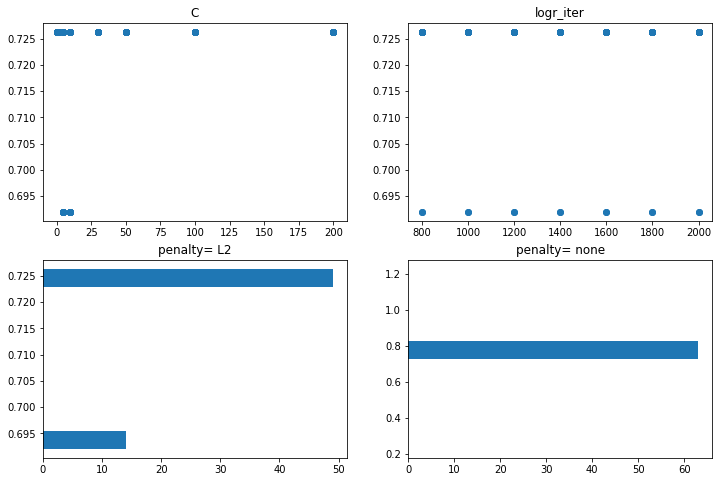

In [217]:
# 
# логистическая регрессия
figure, axis = plt.subplots(2, 2, figsize=(12,8))
axis[0,0].scatter(y=out_logr['accuracy_logr_valid'],x=out_logr['C'])
axis[0,0].set_title('C')
axis[0,1].scatter(y=out_logr['accuracy_logr_valid'],x=out_logr['logr_iter'])
axis[0,1].set_title('logr_iter')
axis[1,0].hist(out_logr[out_logr['penalty']=='l2']['accuracy_logr_valid'],orientation='horizontal')
axis[1,0].set_title('penalty= L2')
axis[1,1].hist(out_logr[out_logr['penalty']=='none']['accuracy_logr_valid'],orientation='horizontal')
axis[1,1].set_title('penalty= none')

plt.show();

Видим, что в целом для лог.регрессии характерно наличие всего двух значений метрики качества.

In [218]:
out_logr['accuracy_logr_valid'].value_counts(normalize=True)

0.726283    0.889764
0.692068    0.110236
Name: accuracy_logr_valid, dtype: float64

72,6% вариантов гиперпараметров для лог.регрессии в результате дают одинаковую модель.
Посмотрим "пустую" модель лог.регрессии- без заданных гиперпараметров

In [219]:
model_logr = LogisticRegression(random_state=12345, solver='lbfgs')
model_logr.fit(features_train, target_train)
predictions_valid = model_logr.predict(features_valid)
print(accuracy_score(target_valid, predictions_valid))

0.7262830482115086


Т.о. можно сделать вывод, что на данной выборке мы можем брать модель лог.регрессии с дефолтными гиперпараметрами (при solver='lbfgs')

#### Несколько параметров. Решающее дерево

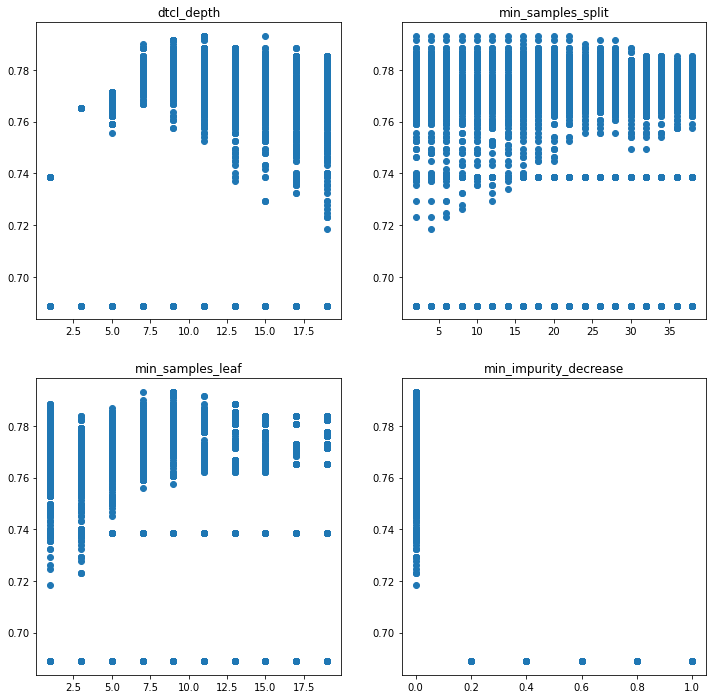

In [220]:
# решающее дерево
figure, axis = plt.subplots(2, 2, figsize=(12,12))
axis[0,0].scatter(y=out_dtcl['accuracy_dtcl_valid'],x=out_dtcl['dtcl_depth'])
axis[0,0].set_title('dtcl_depth')
axis[0,1].scatter(y=out_dtcl['accuracy_dtcl_valid'],x=out_dtcl['min_samples_split'])
axis[0,1].set_title('min_samples_split')
axis[1,0].scatter(y=out_dtcl['accuracy_dtcl_valid'],x=out_dtcl['min_samples_leaf'])
axis[1,0].set_title('min_samples_leaf')
axis[1,1].scatter(y=out_dtcl['accuracy_dtcl_valid'],x=out_dtcl['min_impurity_decrease'])
axis[1,1].set_title('min_impurity_decrease')
plt.show();

Видим, что наибольшее влияние на качество оказывает параметр глубины.

min_impurity_decrease" работает только при значении равном 0

min_sample_leaf дает лучшие результаты при значениях больше 6

min_samle_split можно ставить дефолтный (от 2)

Посмотрим параметры модели решающего дерева - с максимальным качеством

In [221]:
print('Количество итераций с решаюшим деревом: ',out_dtcl.shape[0])
print()
print('Таблица параметров для 5% лучших результатов')
idx = out_dtcl['accuracy_dtcl_valid'].nlargest(out_dtcl.shape[0]//20).index
out_dtcl.loc[idx].head(20)

Количество итераций с решаюшим деревом:  22801

Таблица параметров для 5% лучших результатов


,common_fetch,dtcl_depth,accuracy_dtcl_train,accuracy_dtcl_valid,min_samples_split,min_samples_leaf,min_impurity_decrease,criterion
11450,0.25,11.0,0.847510,0.793157,2.0,9.0,0.0,entropy
11570,0.25,11.0,0.847510,0.793157,4.0,9.0,0.0,entropy
11690,0.25,11.0,0.847510,0.793157,6.0,9.0,0.0,entropy
11810,0.25,11.0,0.847510,0.793157,8.0,9.0,0.0,entropy
11930,0.25,11.0,0.847510,0.793157,10.0,9.0,0.0,entropy
12050,0.25,11.0,0.847510,0.793157,12.0,9.0,0.0,entropy
12170,0.25,11.0,0.847510,0.793157,14.0,9.0,0.0,entropy
12290,0.25,11.0,0.847510,0.793157,16.0,9.0,0.0,entropy
12410,0.25,11.0,0.847510,0.793157,18.0,9.0,0.0,entropy
12530,0.25,11.0,0.847510,0.793157,20.0,9.0,0.0,entropy


Видим, что для лучших вариантов характерны:
- max_depth - 11
- min_samples_split - от 2 и выше (дефолтное значение)
- min_samples_leaf - 9
- criterion - entropy

Посмотрим также как распределено качество для разных критериев

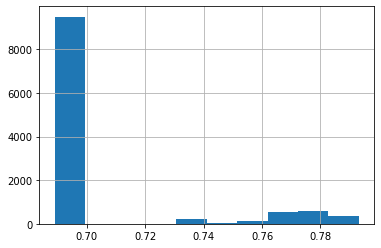

In [222]:
# Gini - для всех комбинаций параметров
out_dtcl[(out_dtcl['criterion']=='gini')]['accuracy_dtcl_valid'].hist();


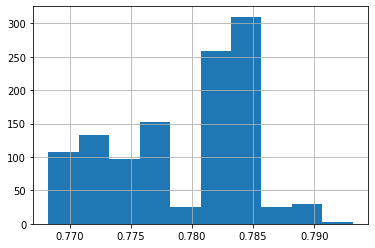

In [223]:
# Gini лучшие 5% оценок
out_dtcl[(out_dtcl['criterion']=='gini')]['accuracy_dtcl_valid'].nlargest(out_dtcl.shape[0]//20).hist();

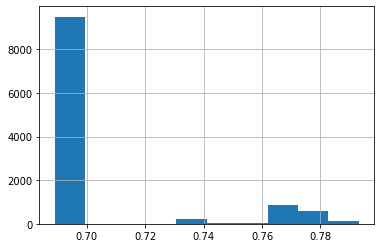

In [224]:
# entropy - для всех комбинаций параметров
out_dtcl[out_dtcl['criterion']=='entropy']['accuracy_dtcl_valid'].hist();

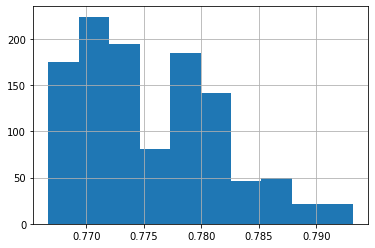

In [225]:
# entropy - для лучших 5% оценок
out_dtcl[out_dtcl['criterion']=='entropy']['accuracy_dtcl_valid'].nlargest(out_dtcl.shape[0]//20).hist();

Посмотрим - какие доли критериев для лучших 1% оценок

In [226]:
idx = out_dtcl['accuracy_dtcl_valid'].nlargest(out_dtcl.shape[0]//100).index
pd.concat((out_dtcl.loc[idx]['criterion'].value_counts(normalize=True),
           out_dtcl.loc[idx]['criterion'].value_counts()), axis=1)

,criterion,criterion
gini,0.596491,136
entropy,0.403509,92


Видим, что в целом критерий не влияет на качество. Но для лучших комбинаций параметров (1%) преобладает критерий entropy

#### Несколько параметров для случайного леса

In [227]:
print('Количество итераций для случайного леса:', out_rfcl.shape[0])

Количество итераций для случайного леса: 5601


Text(0.5, 1.0, 'min_samples_leaf')

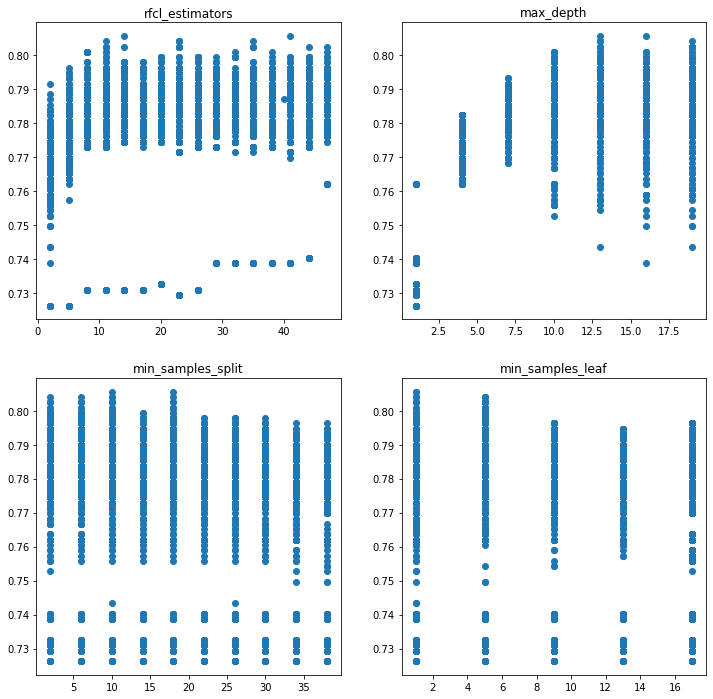

In [228]:
# случайный лес
figure, axis = plt.subplots(2, 2, figsize=(12,12))
axis[0,0].scatter(y=out_rfcl['accuracy_rfcl_valid'],x=out_rfcl['rfcl_estimators'])
axis[0,0].set_title('rfcl_estimators')
axis[0,1].scatter(y=out_rfcl['accuracy_rfcl_valid'],x=out_rfcl['max_depth'])
axis[0,1].set_title('max_depth')
axis[1,0].scatter(y=out_rfcl['accuracy_rfcl_valid'],x=out_rfcl['min_samples_split'])
axis[1,0].set_title('min_samples_split')
axis[1,1].scatter(y=out_rfcl['accuracy_rfcl_valid'],x=out_rfcl['min_samples_leaf'])
axis[1,1].set_title('min_samples_leaf')

Посмотрим лучшие комбинации

In [229]:
print('Количество итераций со случайным лесом: ',out_rfcl.shape[0])
print()
print('Таблица параметров для 5% лучших результатов')
idx = out_rfcl['accuracy_rfcl_valid'].nlargest(out_rfcl.shape[0]//20).index
out_rfcl.loc[idx].head(20)

Количество итераций со случайным лесом:  5601

Таблица параметров для 5% лучших результатов


,common_fetch,rfcl_estimators,accuracy_rfcl_train,accuracy_rfcl_valid,max_depth,min_samples_split,min_samples_leaf
1661,0.25,14.0,0.898340,0.805599,16.0,10.0,1.0
4771,0.25,41.0,0.871369,0.805599,13.0,18.0,1.0
1361,0.25,11.0,0.908195,0.804044,19.0,10.0,1.0
2652,0.25,23.0,0.869813,0.804044,13.0,2.0,5.0
2657,0.25,23.0,0.869813,0.804044,13.0,6.0,5.0
2662,0.25,23.0,0.869813,0.804044,13.0,10.0,5.0
4071,0.25,35.0,0.871888,0.804044,13.0,18.0,1.0
1352,0.25,11.0,0.872925,0.802488,19.0,2.0,5.0
1357,0.25,11.0,0.872925,0.802488,19.0,6.0,5.0
1362,0.25,11.0,0.872925,0.802488,19.0,10.0,5.0


In [230]:
# распределение оценщиков для 5% лучших комбинаций
out_rfcl.loc[idx].rfcl_estimators.value_counts()

11.0    29
23.0    28
14.0    27
47.0    23
29.0    23
44.0    22
17.0    20
8.0     19
26.0    18
20.0    16
32.0    14
41.0    14
38.0    11
35.0    11
5.0      5
Name: rfcl_estimators, dtype: int64

In [232]:
# распределение max_depth для 5% лучших комбинаций
out_rfcl.loc[idx].max_depth.value_counts()

13.0    123
19.0     57
16.0     55
10.0     45
Name: max_depth, dtype: int64

Видим, что
- характерная глубина для Топ20 - 13-19
- min_samples_split для удачных решений можно брать 2
- min_samples_leaf можно брать равным 5
- количество оценщиков - наиболее частое значение в лучших 5% оценок равно 11, при этом значение 23 почти также часто встречается в Топе и это значение сочетается с глубиной 13

Общий вывод: 
- модель логистиеской регрессии устойчива в плане оценок к изменению гиперпараметров, но обладает меньшим из других моделей качеством на валидационной выборке 0.7262.
- модель решающего дерева дает результат (0.7931) лучше логистической регрессии. параметры: max_depth=11, min_samle_leaf = 9, criterion = entropy
- модель случайного леса при анализе гиперпараметров дает самый высокий результат 0.8056. Параметры: n_estimators=41, max_depth=13, min_samples_split=18, min_samples_leaf=1

Таким образом будем тестировать модель случайного леса с указанными параметрами

## Проверьте модель на тестовой выборке

In [236]:
# модель случайного леса дает самый высокий результат 0.810205.
# Параметры: n_estimators=23, max_depth=13, min_samples_split=5
model_rfcl_test = RandomForestClassifier(
        random_state=12345, n_estimators=41,max_depth=13,
        min_samples_leaf=1,min_samples_split=18)
model_rfcl_test.fit(features_train, target_train)
#predictions_valid = model_rfcl_test.predict(features_valid)
#accuracy_rfcl_valid = accuracy_score(target_valid, predictions_valid)
predictions_test = model_rfcl_test.predict(features_test)
accuracy_rfcl_test = accuracy_score(target_test, predictions_test)
"print('Качество на валидационной выборке:',accuracy_rfcl_valid.round(5))
print('Качество на тестовой выборке:',accuracy_rfcl_test.round(5))

Качество на валидационной выборке: 0.8056
Качество на тестовой выборке: 0.79316


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>Получил меньший скор на тесте.

Что же делать? Это зависит от размера ухудшения, от условий исходной задачи и от цены эксперимента. В нашем случае задача - получить оценку выше 0.75 - мы с ней справились. Далее смотрим размер ухудшения: наш случай- снижение на 1,54% (не процентных пункта). Не знаю, конечно, общей практики, но по моему мнению, это допустимо и, соответственно, ничего предпринимать не надо. Ухудшение качества, например, на 5-10% должно свидетельствовать о некачественной (переобученной, недообученной) модели, либо о применении к задаче модели несоответствующего типа. Ну и, если становится понятно, что наше решение (модель) неправильная необходимо учитывать затраты на ее изменение: в нашем случае и в массе других примеров мы просто будем использовать тот же датасет и похожие сплиты на выборки. Доп затраты относительно небольшие: время на перенастройку и обучение. В некоторых задачах, как я понимаю- на порядки более сложных, такой подход "пределаем" не применим в виду его затратности- но в таких задачах должен быть совсем другой подход к планированию и проведению эксперимента. 
    </font>
</div>

## (бонус) Проверьте модели на адекватность

Сравним нашу модель с моделью, предсказывающей наиболее часто встречающийся класс

In [52]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features,target)
print('Качество dummy модели на всей выборке',dummy_clf.score(features,target))
dummy_clf.fit(features_train,target_train)
print('Качество dummy модели, обученной на трен. данных, для тестовой выборки',
      dummy_clf.score(features_test,target_test))

Качество dummy модели на всей выборке 0.693528313627878
Качество dummy модели, обученной на трен. данных, для тестовой выборки 0.6951788491446346


Т.о. нашу модель можно считать адекватной.